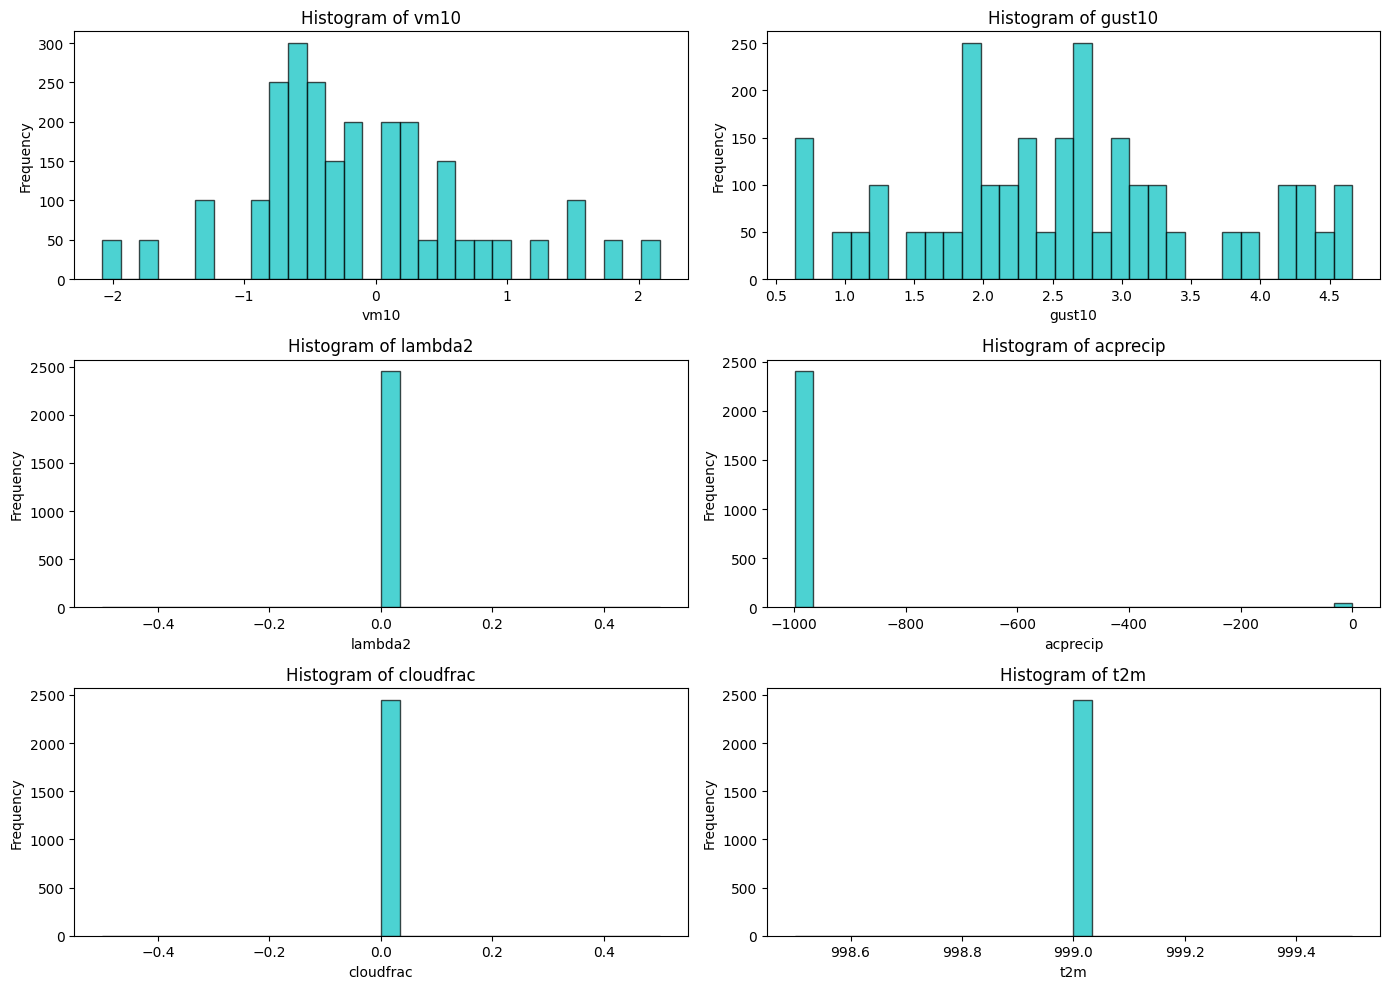

         vm10    gust10  lambda2    acprecip  cloudfrac    t2m
min -2.077934  0.638577      0.0 -999.000000        0.0  999.0
max  2.157765  4.662214      0.0    0.000000        0.0  999.0
std  0.846769  1.055647      0.0  139.888552        0.0    0.0


In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

# Suppress warnings if you prefer not to see them
warnings.filterwarnings("ignore", category=UserWarning, append=True)

# Function to load MESONH data with decode_times=False
def load_mesonh_data(fileinput, lat, lon, month=7):
    # Open the MESONH dataset with decode_times=False to avoid issues with non-standard time units
    ds = xr.open_dataset(fileinput, decode_times=False)
    
    # Assuming the latitude and longitude arrays are named 'x' and 'y' in MESONH
    abs_diff_x = np.abs(ds['x'].values - lon)  # Compare with longitude
    abs_diff_y = np.abs(ds['y'].values - lat)  # Compare with latitude
    
    x_idx = abs_diff_x.argmin().item()
    y_idx = abs_diff_y.argmin().item()

# If the dataset has time and you want to filter by month
#if 'time' in ds.dims:
#    # Convert time variable manually (if it's in seconds since ignition) and ensure nanosecond precision
#    start_time = np.datetime64('2022-07-16T00:00:00', 'ns')  # Nanosecond precision
#    ds['time'] = start_time + ds['time'].astype('timedelta64[ns]')  # Convert to nanoseconds
#    
#    # Select data for the specific month
#    monthly_data = ds.sel(time=ds['time'].dt.month == month)
#    data_at_point = monthly_data.isel(x=x_idx, y=y_idx)
#else:
    data_at_point = ds.isel(x=x_idx, y=y_idx)

    # Convert the data to a DataFrame
    df = data_at_point.to_dataframe().reset_index()

    return df

# Function to load and merge multiple MESONH files
def load_and_merge_mesonh_files(file_list, lat, lon, month=7):
    data_frames = []
    
    for file in file_list:
        df = load_mesonh_data(file, lat, lon, month)
        data_frames.append(df)
    
    # Concatenate all data frames into one
    merged_df = pd.concat(data_frames, ignore_index=True)
    
    return merged_df

# Function to plot histograms for the selected parameters with dynamic grid layout
def plot_histograms(df, parameters):
    num_params = len(parameters)
    
    # Determine the number of rows and columns needed for subplots
    ncols = 2  # Set number of columns to 2
    nrows = (num_params + 1) // ncols  # Calculate the number of rows needed
    
    plt.figure(figsize=(14, 10))
    
    # Loop over the parameters and create subplots dynamically
    for i, param in enumerate(parameters, 1):
        if param in df.columns:
            plt.subplot(nrows, ncols, i)
            plt.hist(df[param].dropna(), bins=30, color='c', edgecolor='k', alpha=0.7)
            plt.title(f'Histogram of {param}')
            plt.xlabel(param)
            plt.ylabel('Frequency')
        else:
            print(f"Warning: {param} not found in the DataFrame columns.")
    
    plt.tight_layout()
    plt.show()

# Function to calculate statistics for selected parameters
def calculate_statistics(df, parameters):
    stats = {}
    
    for param in parameters:
        if param in df.columns:
            min_val = df[param].min()
            max_val = df[param].max()
            std_val = df[param].std()
            
            stats[param] = {
                'min': min_val,
                'max': max_val,
                'std': std_val
            }
        else:
            print(f"Warning: {param} not found in the DataFrame columns.")
    
    return pd.DataFrame(stats)

# Example usage
file_list = ['/data/IMFSE/PythonCourse/MNH/FCAST_model1.nc']  # Replace with your MESONH file paths
lat = 41.709377863541654
lon = 1.892273844304144

# Load and merge data from all MESONH files for July
merged_mesonh_data = load_and_merge_mesonh_files(file_list, lat, lon)

# Plot histograms
parameters_to_plot = ['vm10', 'gust10', 'lambda2', 'acprecip', 'cloudfrac', 't2m']  # Replace with actual parameter names from MESONH files
plot_histograms(merged_mesonh_data, parameters_to_plot)

# Calculate statistics for the parameters
parameters_to_analyze = ['vm10', 'gust10', 'lambda2', 'acprecip', 'cloudfrac', 't2m']  # Replace with actual parameter names
statistics = calculate_statistics(merged_mesonh_data, parameters_to_analyze)

# Display the statistics
print(statistics)